# Notebook to run differential expression analysis on CMC using ´PyDESeq2´

**Created by** : **Srivalli Kolla**

**Developed on** : 11 November,2024  

**Last Modified** : 12 November,2024 

**Institute of Systems Immunology, University of Wurzburg**

Env : pydeseq2

# Importing packages

In [1]:
import scanpy as sc
import anndata
import scipy.sparse as sp
import pandas as pd
from scipy import sparse
import anndata as ad
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import issparse

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from itertools import product

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y,%H:%M")
timestamp

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
asttokens           NA
certifi             2024.07.04
cffi                1.17.1
charset_normalizer  3.4.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
django              5.0.6
executing           2.0.1
h5py                3.11.0
idna                3.10
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
matplotlib          3.9.1
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numpy               1.26.4
packaging           24.1
pandas              2.2.2
parso               0.8.4
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.2
prompt_toolkit      3.0.47
psutil              6.0.0
pure_eval           0.2.2
pydeseq

'12_11_24,17:07'

## Helper Functions

###### From : Christian

In [3]:
def return_highest_weight_pathway(
        genes: pd.Index,
        progeny_df: pd.DataFrame 
):
    sorted_progeny_df = progeny_df.sort_values(["weight", "target"], ascending=[False, True])
    highest_weight_sources = sorted_progeny_df.drop_duplicates(subset="target", keep="first").set_index("target")["source"]
    return genes.map(lambda gene: highest_weight_sources.get(gene, pd.NA))

def annotate_var_pathways(adata, progeny_df):
    annotated_adata = adata.copy()
    annotated_adata.var = annotated_adata.var.assign(source=lambda x: return_highest_weight_pathway(x.index, progeny_df))
    return annotated_adata

def pseudobulk_from_adata(adata: ad.AnnData) -> ad.AnnData:
    return ad.AnnData(
        X=sparse.csr_matrix(adata.X.toarray().sum(axis=0)),
        obs=adata.obs[filter(lambda column: len(set(adata.obs[column])) == 1, adata.obs.columns)].head(1),
        var=adata.var
    )

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

# Data Import

In [5]:
a = sc.read_h5ad('../data/dmd_annotated_human_wt_cmc_1k_hvg_25_10_24,11:40.h5ad')
a

AnnData object with n_obs × n_vars = 56602 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_count

In [6]:
X_is_raw(a)

True

In [7]:
b = sc.read_h5ad('../data/dmd_annotated_wt_others_cmc_5k_hvg_25_10_24,11:49.h5ad')
b

AnnData object with n_obs × n_vars = 28090 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_count

In [8]:
X_is_raw(b)

False

In [9]:
b.X = b.layers['raw_counts']
X_is_raw(b)

True

In [10]:
adata = a.concatenate(b)
adata

AnnData object with n_obs × n_vars = 84692 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_count

# Dataprep for deseq

In [11]:
adata.obs['sample'].value_counts()

sample
A10_2    54763
B1_2     20203
B2_2      4797
A9_2      1839
A12_2     1591
A11_2     1499
Name: count, dtype: int64

In [12]:
X_is_raw(adata)

True

In [13]:
pseudobulk = ad.concat(map(pseudobulk_from_adata, map(lambda batch: adata[adata.obs["sample"] == batch],set(adata.obs["sample"]))))
pseudobulk

AnnData object with n_obs × n_vars = 6 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_leiden', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype'

In [14]:
counts_df = pd.DataFrame(pseudobulk.X.toarray().astype(int), index=pseudobulk.obs_names, columns=pseudobulk.var_names)
metadata = pseudobulk.obs

In [15]:
counts_df

Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  \
CTCAACCAGATCCAAA-1-0                 7       0        1        3   64      6   
GCTCAAATCCGCAACG-1-query-query-1    19       4        3        6  174     21   
CTGCAGGGTTCGGACC-1-query-query-1    10       0        5        6   36     34   
ACACCAAAGAGGTATT-1-query-query-1    77       6        8       38  269    169   
TAATTCCTCTACTCAT-1-0               105      16        3        9  221    278   
TGATTCTCATACCGTA-1-query-query-1     0       0        0       14  394      3   

                                  Gm37587  Gm37323  Mrpl15  Lypla1  ...  \
CTCAACCAGATCCAAA-1-0                    1        0     238     166  ...   
GCTCAAATCCGCAACG-1-query-query-1        0        0     365     599  ...   
CTGCAGGGTTCGGACC-1-query-query-1        0        0     228     303  ...   
ACACCAAAGAGGTATT-1-query-query-1        6        1    1124    1513  ...   
TAATTCCTCTACTCAT-1-0                    4        0    5179    2408  ...   
TGATTCTCATACCGTA-1-query-query-1        1        0     435     743  ...   

                                  Vmn2r122  Il11ra2-1  Ccl27a-1  Ccl21c-1  \
CTCAACCAGATCCAAA-1-0                     0          0         0         0   
GCTCAAATCCGCAACG-1-query-query-1         0          0         0         0   
CTGCAGGGTTCGGACC-1-query-query-1         0          0         0         0   
ACACCAAAGAGGTATT-1-query-query-1         0          0         0         0   
TAATTCCTCTACTCAT-1-0                     0          0         0         0   
TGATTCTCATACCGTA-1-query-query-1         0          0         0         0   

                                  Ccl27a-2  Il11ra2-2  Ccl19-1  Ccl21a-1  \
CTCAACCAGATCCAAA-1-0                     0          0        0         0   
GCTCAAATCCGCAACG-1-query-query-1         0          0        0         0   
CTGCAGGGTTCGGACC-1-query-query-1         0          0        0         0   
ACACCAAAGAGGTATT-1-query-query-1         0          0        0         0   
TAATTCCTCTACTCAT-1-0                     0          0        0         0   
TGATTCTCATACCGTA-1-query-query-1         0          0        0         0   

                                  Gm10931  Gm16367  
CTCAACCAGATCCAAA-1-0                    0        0  
GCTCAAATCCGCAACG-1-query-query-1        0        0  
CTGCAGGGTTCGGACC-1-query-query-1        1        0  
ACACCAAAGAGGTATT-1-query-query-1        1        0  
TAATTCCTCTACTCAT-1-0                    0        0  
TGATTCTCATACCGTA-1-query-query-1        0        0  

[6 rows x 29378 columns]

In [16]:
metadata

sangerID combinedID donor donor_type region  \
CTCAACCAGATCCAAA-1-0                  NaN        NaN   NaN        NaN    NaN   
GCTCAAATCCGCAACG-1-query-query-1      NaN        NaN   NaN        NaN    NaN   
CTGCAGGGTTCGGACC-1-query-query-1      NaN        NaN   NaN        NaN    NaN   
ACACCAAAGAGGTATT-1-query-query-1      NaN        NaN   NaN        NaN    NaN   
TAATTCCTCTACTCAT-1-0                  NaN        NaN   NaN        NaN    NaN   
TGATTCTCATACCGTA-1-query-query-1      NaN        NaN   NaN        NaN    NaN   

                                 region_finest  age gender facility  \
CTCAACCAGATCCAAA-1-0                       NaN  NaN    NaN      NaN   
GCTCAAATCCGCAACG-1-query-query-1           NaN  NaN    NaN      NaN   
CTGCAGGGTTCGGACC-1-query-query-1           NaN  NaN    NaN      NaN   
ACACCAAAGAGGTATT-1-query-query-1           NaN  NaN    NaN      NaN   
TAATTCCTCTACTCAT-1-0                       NaN  NaN    NaN      NaN   
TGATTCTCATACCGTA-1-query-query-1           NaN  NaN    NaN      NaN   

                                 cell_or_nuclei  ... _scvi_labels clus20  \
CTCAACCAGATCCAAA-1-0                        NaN  ...            5    NaN   
GCTCAAATCCGCAACG-1-query-query-1            NaN  ...            5    NaN   
CTGCAGGGTTCGGACC-1-query-query-1            NaN  ...            5    NaN   
ACACCAAAGAGGTATT-1-query-query-1            NaN  ...            5    NaN   
TAATTCCTCTACTCAT-1-0                        NaN  ...            5    NaN   
TGATTCTCATACCGTA-1-query-query-1            NaN  ...            5    NaN   

                                 doublet_cls original_or_new batch  \
CTCAACCAGATCCAAA-1-0                     NaN             NaN     0   
GCTCAAATCCGCAACG-1-query-query-1         NaN             NaN     1   
CTGCAGGGTTCGGACC-1-query-query-1         NaN             NaN     1   
ACACCAAAGAGGTATT-1-query-query-1         NaN             NaN     1   
TAATTCCTCTACTCAT-1-0                     NaN             NaN     0   
TGATTCTCATACCGTA-1-query-query-1         NaN             NaN     1   

                                 scANVI_predictions leiden_scArches sample  \
CTCAACCAGATCCAAA-1-0                            NaN             NaN   A9_2   
GCTCAAATCCGCAACG-1-query-query-1                NaN             NaN  A11_2   
CTGCAGGGTTCGGACC-1-query-query-1                NaN             NaN   B2_2   
ACACCAAAGAGGTATT-1-query-query-1                NaN             NaN   B1_2   
TAATTCCTCTACTCAT-1-0                            NaN             NaN  A10_2   
TGATTCTCATACCGTA-1-query-query-1                NaN             NaN  A12_2   

                                 seed_labels  genotype  
CTCAACCAGATCCAAA-1-0                 Unknown        WT  
GCTCAAATCCGCAACG-1-query-query-1     Unknown       Mdx  
CTGCAGGGTTCGGACC-1-query-query-1     Unknown   MdxSCID  
ACACCAAAGAGGTATT-1-query-query-1     Unknown   MdxSCID  
TAATTCCTCTACTCAT-1-0                 Unknown        WT  
TGATTCTCATACCGTA-1-query-query-1     Unknown       Mdx  

[6 rows x 30 columns]

# DeSeq

In [17]:
inference = DefaultInference(n_cpus=8)

WT_dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors='genotype',  
    refit_cooks=True,
    inference=inference, ref_level = ('genotype', 'WT')
)

In [18]:
inference = DefaultInference(n_cpus=8)

Mdx_dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors='genotype',  
    refit_cooks=True,
    inference=inference, ref_level = ('genotype', 'Mdx')
)

In [19]:
inference = DefaultInference(n_cpus=8)

MdxSCID_dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors='genotype',  
    refit_cooks=True,
    inference=inference, ref_level = ('genotype', 'MdxSCID')
)

In [20]:
WT_dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.41 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

/home/skolla/miniforge3/envs/pydeseq2/lib/python3.12/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.33 seconds.

Fitting LFCs...
... done in 1.42 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [21]:
Mdx_dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.24 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

/home/skolla/miniforge3/envs/pydeseq2/lib/python3.12/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.29 seconds.

Fitting LFCs...
... done in 1.37 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [22]:
MdxSCID_dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.25 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

/home/skolla/miniforge3/envs/pydeseq2/lib/python3.12/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.34 seconds.

Fitting LFCs...
... done in 1.38 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [23]:
stat_res1 = DeseqStats(WT_dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res1.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: genotype MdxSCID vs WT
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.351047       -0.001806  1.142346 -0.001581  0.998738  0.999509
Gm1992       2.148276       -1.191648  2.751418 -0.433103  0.664940       NaN
Gm19938      3.760212        2.278377  1.967799  1.157830  0.246933       NaN
Gm37381     10.087941        1.719037  1.199661  1.432936  0.151876       NaN
Rp1        162.752680       -0.148755  0.609255 -0.244158  0.807108  0.999022
...               ...             ...       ...       ...       ...       ...
Il11ra2-2    0.000000             NaN       NaN       NaN       NaN       NaN
Ccl19-1      0.000000             NaN       NaN       NaN       NaN       NaN
Ccl21a-1     0.000000             NaN       NaN       NaN       NaN       NaN
Gm10931      0.493435        3.027104  5.301439  0.570997  0.568002       NaN
Gm16367      0.000000             NaN       NaN       NaN       NaN       NaN

[2

... done in 4.04 seconds.



In [24]:
stat_res2 = DeseqStats(Mdx_dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res2.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: genotype MdxSCID vs Mdx
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.351047        1.589591  1.167703  1.361297  0.173420  0.382746
Gm1992       2.148276       -0.455338  2.770747 -0.164338  0.869465       NaN
Gm19938      3.760212        2.335550  1.955642  1.194263  0.232375       NaN
Gm37381     10.087941        0.710395  1.141820  0.622160  0.533836  0.720880
Rp1        162.752680       -1.397656  0.602734 -2.318859  0.020403  0.096795
...               ...             ...       ...       ...       ...       ...
Il11ra2-2    0.000000             NaN       NaN       NaN       NaN       NaN
Ccl19-1      0.000000             NaN       NaN       NaN       NaN       NaN
Ccl21a-1     0.000000             NaN       NaN       NaN       NaN       NaN
Gm10931      0.493435        2.977389  5.245294  0.567630  0.570286       NaN
Gm16367      0.000000             NaN       NaN       NaN       NaN       NaN

[

... done in 1.40 seconds.



In [25]:
stat_res3 = DeseqStats(MdxSCID_dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res3.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: genotype WT vs MdxSCID
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.351047        0.001815  1.142222  0.001589  0.998732  0.999534
Gm1992       2.148276        1.191614  2.750653  0.433211  0.664861       NaN
Gm19938      3.760212       -2.278380  1.967357 -1.158092  0.246826       NaN
Gm37381     10.087941       -1.719074  1.199444 -1.433226  0.151793       NaN
Rp1        162.752680        0.148761  0.609315  0.244144  0.807119  0.999159
...               ...             ...       ...       ...       ...       ...
Il11ra2-2    0.000000             NaN       NaN       NaN       NaN       NaN
Ccl19-1      0.000000             NaN       NaN       NaN       NaN       NaN
Ccl21a-1     0.000000             NaN       NaN       NaN       NaN       NaN
Gm10931      0.493435       -3.027099  5.301472 -0.570992  0.568005       NaN
Gm16367      0.000000             NaN       NaN       NaN       NaN       NaN

[2

... done in 1.25 seconds.



In [26]:
stat_res1.results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.351047       -0.001806  1.142346 -0.001581  0.998738  0.999509
Gm1992       2.148276       -1.191648  2.751418 -0.433103  0.664940       NaN
Gm19938      3.760212        2.278377  1.967799  1.157830  0.246933       NaN
Gm37381     10.087941        1.719037  1.199661  1.432936  0.151876       NaN
Rp1        162.752680       -0.148755  0.609255 -0.244158  0.807108  0.999022
...               ...             ...       ...       ...       ...       ...
Il11ra2-2    0.000000             NaN       NaN       NaN       NaN       NaN
Ccl19-1      0.000000             NaN       NaN       NaN       NaN       NaN
Ccl21a-1     0.000000             NaN       NaN       NaN       NaN       NaN
Gm10931      0.493435        3.027104  5.301439  0.570997  0.568002       NaN
Gm16367      0.000000             NaN       NaN       NaN       NaN       NaN

[29378 rows x 6 columns]

In [27]:
stat_res1.results_df.to_csv(f'../differential_gene_expression/DE_results/DE_pydeseq2_cmc_Wt_vs_all_{timestamp}.tsv')
stat_res2.results_df.to_csv(f'../differential_gene_expression/DE_results/DE_pydeseq2_cmc__Mdx_vs_all_{timestamp}.tsv')
stat_res3.results_df.to_csv(f'../differential_gene_expression/DE_results/DE_pydeseq2_cmc_Mdxscid_vs_all_{timestamp}.tsv')

# Enrichr annotations

## Wt_vs_all

In [28]:
filtered = stat_res1.results_df[stat_res1.results_df['log2FoldChange'] > 0.5]
filtered

baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
Gm19938   3.760212        2.278377  1.967799  1.157830  0.246933   NaN
Gm37381  10.087941        1.719037  1.199661  1.432936  0.151876   NaN
Gm37323   0.069963        1.356063  5.486359  0.247170  0.804777   NaN
Rgs20     8.517653        1.332826  1.257297  1.060073  0.289111   NaN
Gm16041   0.069963        1.356063  5.486359  0.247170  0.804777   NaN
...            ...             ...       ...       ...       ...   ...
Gm20843   0.069963        1.356063  5.486359  0.247170  0.804777   NaN
Gm29564   0.069963        1.356063  5.486359  0.247170  0.804777   NaN
Gm28897   1.178269        1.424851  3.409677  0.417885  0.676032   NaN
Spry3     0.205268        0.691444  5.094767  0.135717  0.892045   NaN
Gm10931   0.493435        3.027104  5.301439  0.570997  0.568002   NaN

[6738 rows x 6 columns]

In [29]:
filtered.index = filtered.index.str.upper()
filtered.index

Index(['GM19938', 'GM37381', 'GM37323', 'RGS20', 'GM16041', 'ATP6V1H', 'OPRK1',
       'ST18', 'MYBL1', 'VCPIP1',
       ...
       'GM36467', 'GM21094', 'GM21865', 'GM28961', 'GM28612', 'GM20843',
       'GM29564', 'GM28897', 'SPRY3', 'GM10931'],
      dtype='object', length=6738)

In [30]:
genes = filtered.index.tolist()  
genes

['GM19938',
 'GM37381',
 'GM37323',
 'RGS20',
 'GM16041',
 'ATP6V1H',
 'OPRK1',
 'ST18',
 'MYBL1',
 'VCPIP1',
 'SGK3',
 'GM15818',
 'TRAM1',
 'MSC',
 'TRPA1',
 'RDH10',
 'STAU2',
 'GM28783',
 'GDAP1',
 'GM28784',
 'PI15',
 'GM28154',
 'GM16070',
 'CRISPLD1',
 'GM15825',
 'TFAP2D',
 'TFAP2B',
 'GM28653',
 'IL17F',
 'GSTA3',
 'GM28836',
 'KHDC1A',
 'KHDC1C',
 'KHDC1B',
 'KCNQ5',
 'RIMS1',
 'GM27028',
 'COL19A1',
 'GM5524',
 'PTP4A1',
 'GM37724',
 'ZFP451',
 'BEND6',
 'GM37233',
 'GM28306',
 'GM28417',
 'GM28415',
 'GM33222',
 'GM33280',
 'UGGT1',
 'ARID5A',
 'CNNM4',
 'ANKRD39',
 'ZAP70',
 'VWA3B',
 'GM26805',
 'LYG2',
 'GM16150',
 'GM37821',
 'RNF149',
 'CREG2',
 'IL1RL2',
 'IL1RL1',
 'IL18R1',
 'IL18RAP',
 'GM35801',
 'GM29260',
 'GM28140',
 'GM20646',
 'GPR45',
 'GM8251',
 'METTL21E',
 'COL3A1',
 'COL5A2',
 'GM5269',
 'DNAH7B',
 'DNAH7C',
 'SLC39A10',
 'GM28151',
 'TMEFF2',
 'GM28322',
 'GM29325',
 'GM17767',
 'GM28055',
 'GM29453',
 'STAT4',
 'GM553',
 'GM28178',
 'MFSD6',
 'STK17B',

1. Provide all necessary url and 
2. Get the list of databases available to access

In [31]:
enrichr_add_list_url = "https://maayanlab.cloud/Enrichr/addList"
enrichr_enrich_url = "https://maayanlab.cloud/Enrichr/enrich"
enrichr_background_url = "https://maayanlab.cloud/Enrichr/datasetStatistics"

response = requests.get(enrichr_background_url)
databases = response.json() 

for db in databases['statistics']:
    print(db['libraryName'])

Genome_Browser_PWMs
TRANSFAC_and_JASPAR_PWMs
Transcription_Factor_PPIs
ChEA_2013
Drug_Perturbations_from_GEO_2014
ENCODE_TF_ChIP-seq_2014
BioCarta_2013
Reactome_2013
WikiPathways_2013
Disease_Signatures_from_GEO_up_2014
KEGG_2013
TF-LOF_Expression_from_GEO
TargetScan_microRNA
PPI_Hub_Proteins
GO_Molecular_Function_2015
GeneSigDB
Chromosome_Location
Human_Gene_Atlas
Mouse_Gene_Atlas
GO_Cellular_Component_2015
GO_Biological_Process_2015
Human_Phenotype_Ontology
Epigenomics_Roadmap_HM_ChIP-seq
KEA_2013
NURSA_Human_Endogenous_Complexome
CORUM
SILAC_Phosphoproteomics
MGI_Mammalian_Phenotype_Level_3
MGI_Mammalian_Phenotype_Level_4
Old_CMAP_up
Old_CMAP_down
OMIM_Disease
OMIM_Expanded
VirusMINT
MSigDB_Computational
MSigDB_Oncogenic_Signatures
Disease_Signatures_from_GEO_down_2014
Virus_Perturbations_from_GEO_up
Virus_Perturbations_from_GEO_down
Cancer_Cell_Line_Encyclopedia
NCI-60_Cancer_Cell_Lines
Tissue_Protein_Expression_from_ProteomicsDB
Tissue_Protein_Expression_from_Human_Proteome_Map
HM

Select the database and set the batch size for processing 

In [32]:
batch_size = 500
gene_batches = [genes[i:i + batch_size] for i in range(0, len(genes), batch_size)]


background_type = "Reactome_2022"


pathway_results = {}

1. Create a loop to submit the gene list in batches 
2. Check the output if Gene, Pathway cols are present if yes consider, if not select col 1,5 for pathway and gene specifically


In [33]:
for i, gene_batch in enumerate(gene_batches):
    genes_str = '\n'.join(gene_batch)  
    payload = {'list': (None, genes_str), 'description': f'Pathway enrichment batch {i+1}'}


    for attempt in range(3):
        try:

            response = requests.post(enrichr_add_list_url, files=payload, timeout=10)
            if response.status_code == 200:
                user_list_id = response.json()['userListId']
                print(f"Batch {i+1} submitted successfully. User list ID: {user_list_id}")
                

                enrich_response = requests.get(f"{enrichr_enrich_url}?userListId={user_list_id}&backgroundType={background_type}", timeout=10)
                if enrich_response.status_code == 200:
                    enrichment_results = enrich_response.json()

                    if background_type in enrichment_results:
                        batch_df = pd.DataFrame(enrichment_results[background_type])

    
                        if len(batch_df) > 0:
                            if 'Term' in batch_df.columns:
                                pathway_column = 'Term'
                                genes_column = 'Genes'
                            elif 'Pathway' in batch_df.columns:
                                pathway_column = 'Pathway'
                                genes_column = 'Genes'
                            elif 1 in batch_df.columns and 5 in batch_df.columns:

                                pathway_column = 1
                                genes_column = 5
                            else:
                                print("Warning: Unknown pathway column structure in response.")
                                print("Unexpected batch structure:", batch_df.head())
                                continue


                            for _, row in batch_df.iterrows():
                                pathway = row[pathway_column]
                                genes_in_pathway = row[genes_column]

                                for gene in genes_in_pathway:
                                    if gene in pathway_results:
                                        pathway_results[gene].append(pathway)
                                    else:
                                        pathway_results[gene] = [pathway]
                break
            else:
                print(f"Error submitting batch {i+1} (Status code: {response.status_code})")
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for batch {i+1}: {e}")


Batch 1 submitted successfully. User list ID: 85701025
Batch 2 submitted successfully. User list ID: 85701026
Batch 3 submitted successfully. User list ID: 85701027
Batch 4 submitted successfully. User list ID: 85701028
Batch 5 submitted successfully. User list ID: 85701030
Batch 6 submitted successfully. User list ID: 85701031
Batch 7 submitted successfully. User list ID: 85701032
Batch 8 submitted successfully. User list ID: 85701035
Batch 9 submitted successfully. User list ID: 85701036
Batch 10 submitted successfully. User list ID: 85701038
Batch 11 submitted successfully. User list ID: 85701039
Batch 12 submitted successfully. User list ID: 85701040
Batch 13 submitted successfully. User list ID: 85701042
Batch 14 submitted successfully. User list ID: 85701044


Obtain the pathways for genes provided

In [34]:
pathway_results = {gene: ', '.join(pathways) for gene, pathways in pathway_results.items()}
pathways_df = pd.DataFrame.from_dict(pathway_results, orient='index', columns=['Pathways']).reset_index()
pathways_df.columns = ['Gene', 'Pathways']

filtered_with_pathways = filtered.merge(pathways_df, how='left', left_index=True, right_on='Gene')

filtered_with_pathways['Pathways'] = filtered_with_pathways['Pathways'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
print(filtered_with_pathways[['Gene', 'Pathways']])

          Gene                                           Pathways
NaN    GM19938                                                 []
NaN    GM37381                                                 []
NaN    GM37323                                                 []
169.0    RGS20  [Signaling By GPCR R-HSA-372790, G Alpha (I) S...
NaN    GM16041                                                 []
...        ...                                                ...
NaN    GM20843                                                 []
NaN    GM29564                                                 []
NaN    GM28897                                                 []
NaN      SPRY3                                                 []
NaN    GM10931                                                 []

[6738 rows x 2 columns]


In [35]:
all_pathways = filtered_with_pathways['Pathways'].explode().dropna().unique().tolist()
all_pathways

['Signaling By GPCR R-HSA-372790',
 'G Alpha (I) Signaling Events R-HSA-418594',
 'G Alpha (Z) Signaling Events R-HSA-418597',
 'GPCR Downstream Signaling R-HSA-388396',
 'Signal Transduction R-HSA-162582',
 'Nef-mediated Downmodulation Of Cell Surface Receptors By Recruitment To Clathrin Adapters R-HSA-164938',
 'Role Of Nef In HIV-1 Replication And Disease Pathogenesis R-HSA-164952',
 'Infection With Mycobacterium Tuberculosis R-HSA-9635486',
 'Nef Mediated CD8 Down-regulation R-HSA-182218',
 'Transferrin Endocytosis And Recycling R-HSA-917977',
 'Nef Mediated CD4 Down-regulation R-HSA-167590',
 'ROS And RNS Production In Phagocytes R-HSA-1222556',
 'Ion Channel Transport R-HSA-983712',
 'Suppression Of Phagosomal Maturation R-HSA-9637687',
 'Amino Acids Regulate mTORC1 R-HSA-9639288',
 'Response Of Mtb To Phagocytosis R-HSA-9637690',
 'Iron Uptake And Transport R-HSA-917937',
 'Insulin Receptor Recycling R-HSA-77387',
 'Immune System R-HSA-168256',
 'Host Interactions Of HIV Factors

Obtain the count of genes for each Pathway along with their Gene list

In [36]:
pathway_gene_counts = {}

for index, row in filtered_with_pathways.iterrows():
    gene_name = row['Gene']  
    pathways = row['Pathways']  
    

    for pathway in pathways:

        if pathway in pathway_gene_counts:
            pathway_gene_counts[pathway]['Gene Count'] += 1
            pathway_gene_counts[pathway]['Genes'].add(gene_name)  
        else:

            pathway_gene_counts[pathway] = {'Gene Count': 1, 'Genes': {gene_name}}


pathway_counts_df = pd.DataFrame([
    {'Pathway': pathway, 'Gene Count': data['Gene Count'], 'Genes': sorted(data['Genes'])}
    for pathway, data in pathway_gene_counts.items()
])


pathway_counts_df = pathway_counts_df.sort_values(by='Gene Count', ascending=False)
pathway_counts_df

Pathway  Gene Count  \
4                      Signal Transduction R-HSA-162582         617   
18                           Immune System R-HSA-168256         489   
26                                Disease R-HSA-1643685         368   
77                             Metabolism R-HSA-1430728         346   
43                  Metabolism Of Proteins R-HSA-392499         305   
...                                                 ...         ...   
1644  SIRT1 Negatively Regulates rRNA Expression R-H...           1   
1646       RNA Polymerase I Promoter Escape R-HSA-73772           1   
1647        G2/M DNA Replication Checkpoint R-HSA-69478           1   
1648               Response To Metal Ions R-HSA-5660526           1   
1650  CLEC7A (Dectin-1) Induces NFAT Activation R-HS...           1   

                                                  Genes  
4     [ABCA1, ABCG1, ABCG8, ABHD12, ABL1, ACKR1, ACK...  
18    [ABCA13, ABL1, ACLY, ACTR2, ADAM10, ADAM17, AD...  
26    [ABCA1, ABCA12, ABCB11, ABCC9, ABCG8, ABL1, AC...  
77    [AADAC, AASS, ABCA1, ABCB11, ABCC3, ABHD3, ACA...  
43    [ACE, ACHE, ADAM10, ADAMTS1, ADAMTS15, ADAMTS1...  
...                                                 ...  
1644                                              [TBP]  
1646                                              [TBP]  
1647                                           [PKMYT1]  
1648                                           [PKMYT1]  
1650                                            [ITPR3]  

[1695 rows x 3 columns]

In [37]:
apoptosis_related1 = pathway_counts_df[pathway_counts_df['Pathway'].str.contains("apoptosis", case=False)]

apoptosis_related1

Pathway  Gene Count  \
607                              Apoptosis R-HSA-109581          21   
783        Intrinsic Pathway For Apoptosis R-HSA-109606           9   
849   Defective Intrinsic Pathway For Apoptosis R-HS...           5   
1351  TP53 Regulates Transcription Of Additional Cel...           2   
1439   Apoptosis Induced DNA Fragmentation R-HSA-140342           1   
1404             Suppression Of Apoptosis R-HSA-9635465           1   

                                                  Genes  
607   [APAF1, BMF, CASP3, CLSPN, DAPK1, DBNL, E2F1, ...  
783   [APAF1, BMF, CASP3, E2F1, GZMB, MAPK3, PMAIP1,...  
849                  [APP, CAPNS2, CDC25B, ERC2, FOXO3]  
1351                                   [BCL2L14, NDRG1]  
1439                                            [CASP3]  
1404                                            [MAPK3]

## Plotting Pathways

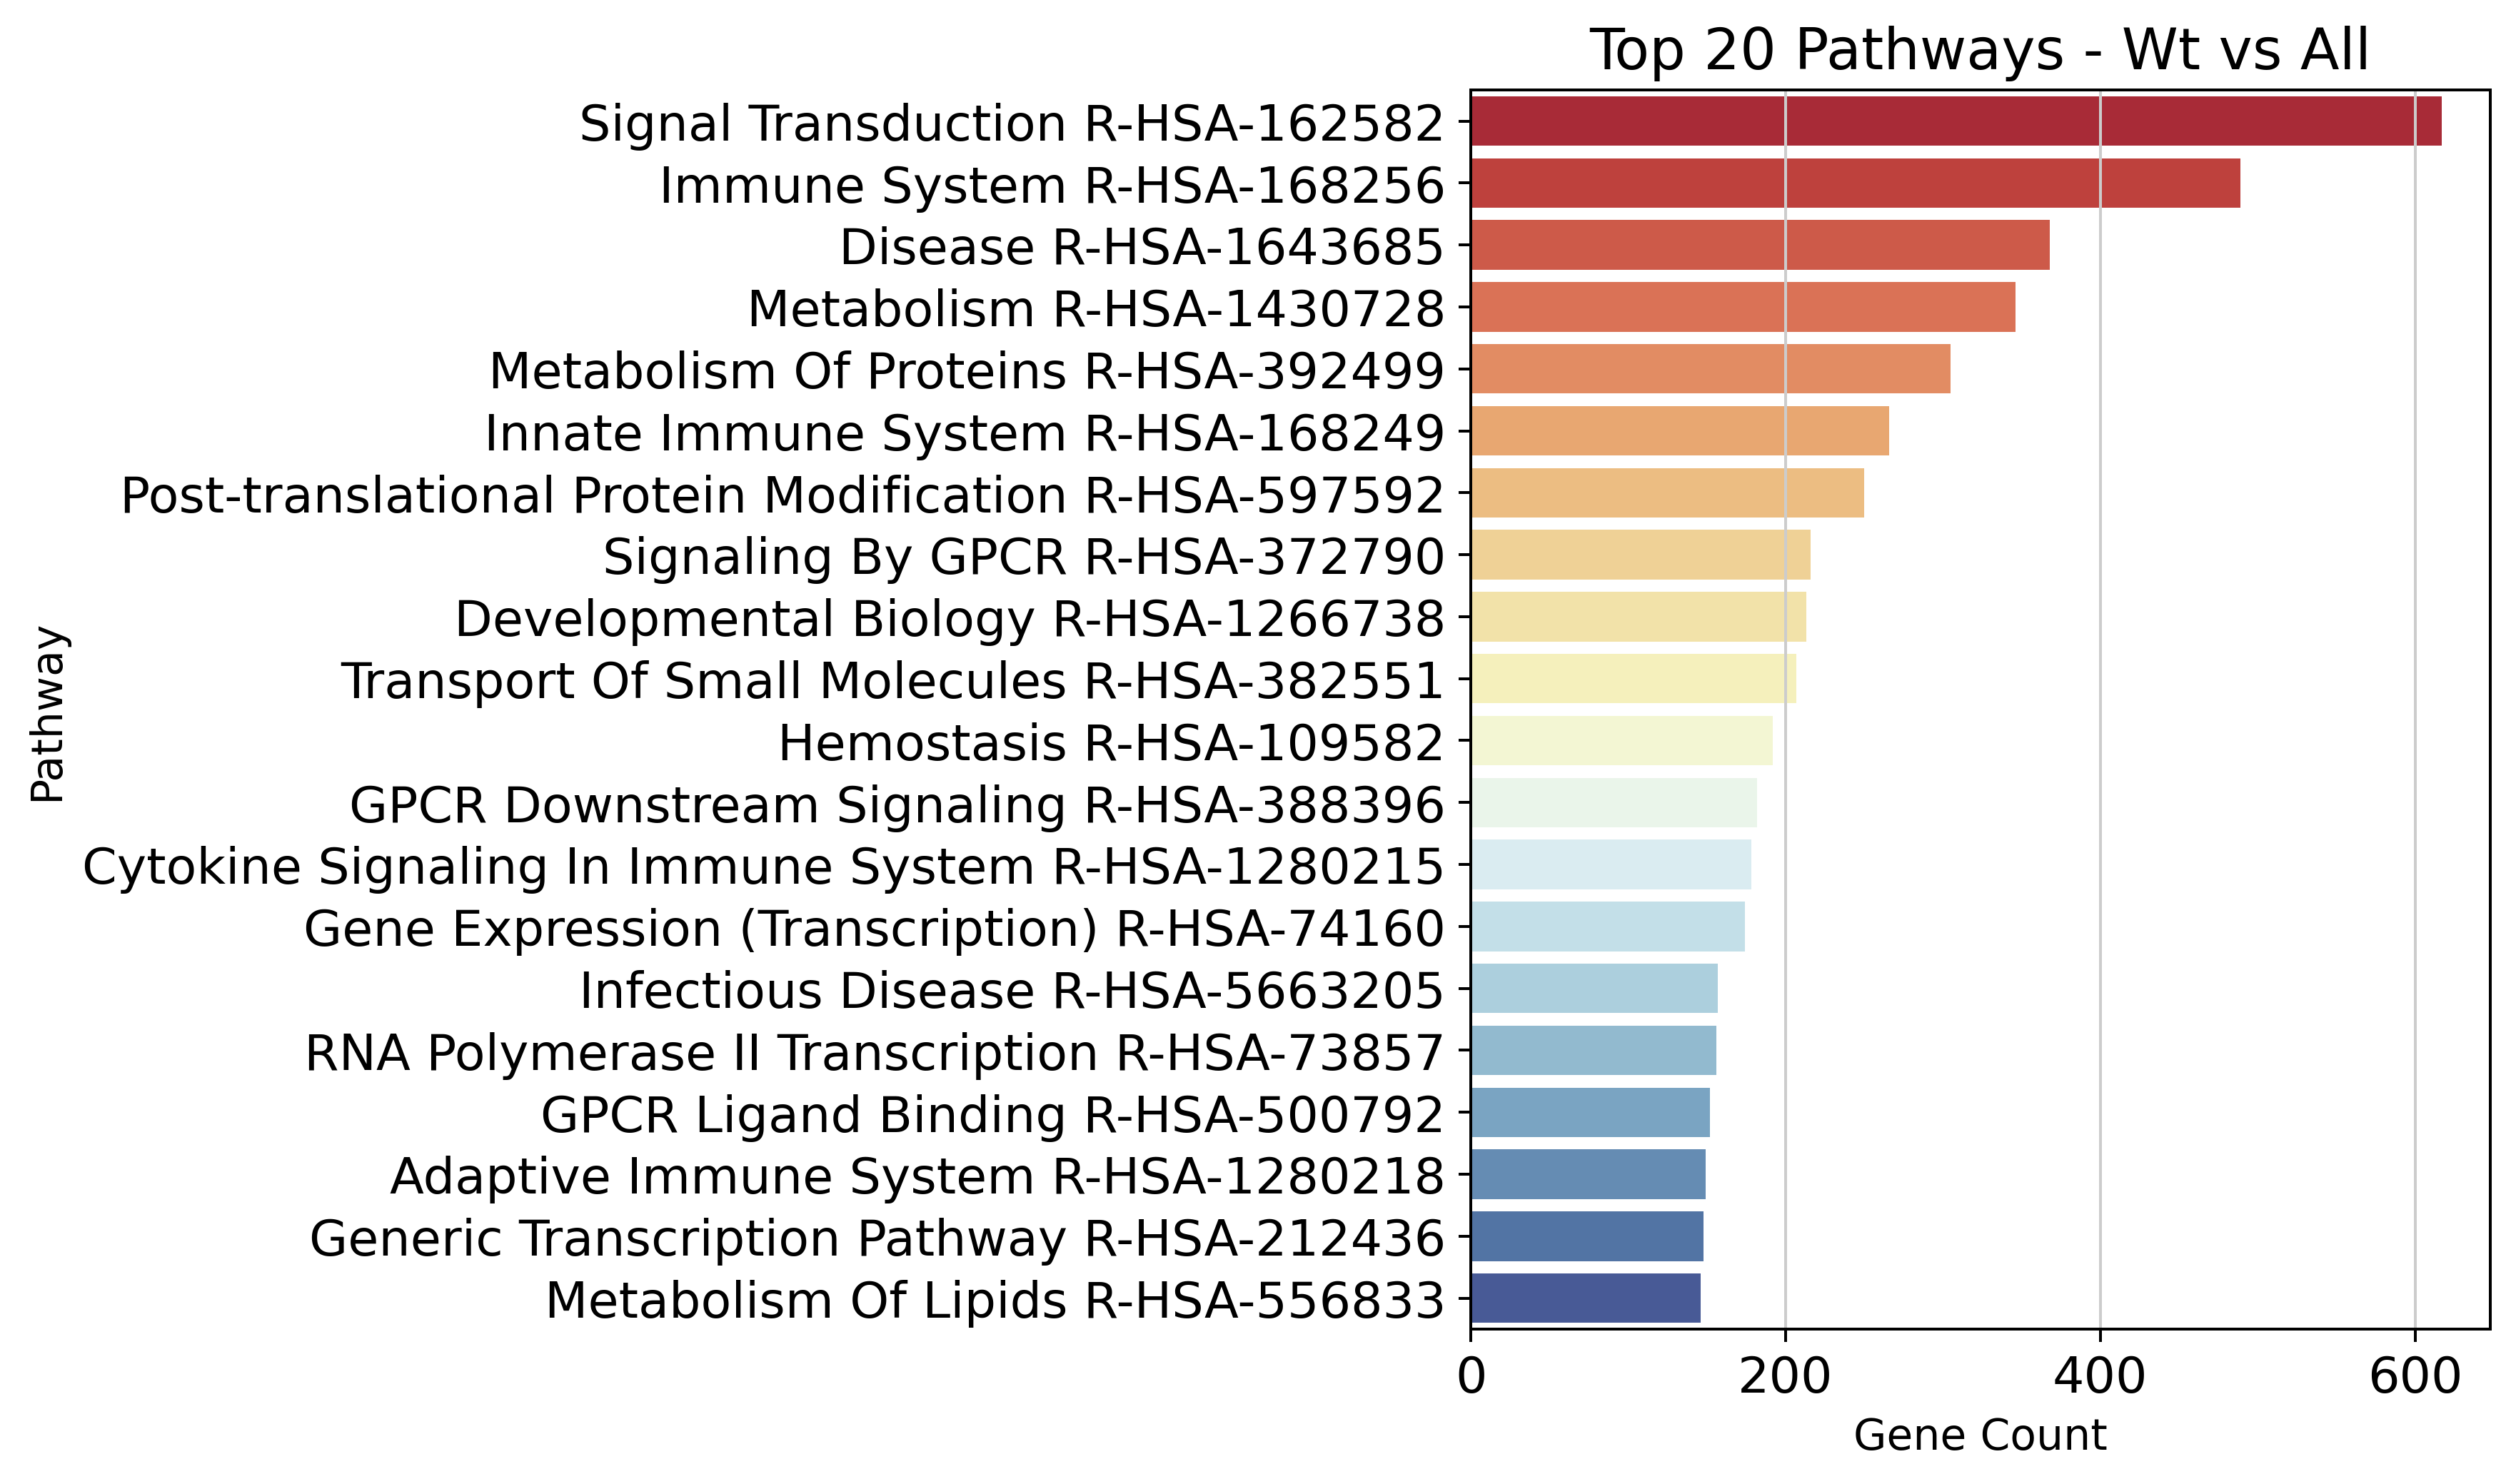

In [38]:
pathway_counts_sorted = pathway_counts_df.sort_values(by='Gene Count', ascending=False)

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Gene Count', y='Pathway', data=pathway_counts_sorted.head(top_n), palette='RdYlBu')
plt.title(f"Top {top_n} Pathways - Wt vs All", fontsize=16)
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Pathway', fontsize=12)
plt.tight_layout()
plt.show()

## Mdx_vs_all

In [39]:
filtered = stat_res2.results_df[stat_res2.results_df['log2FoldChange'] > 0.5]
filtered

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4      22.351047        1.589591  1.167703  1.361297  0.173420  0.382746
Gm19938    3.760212        2.335550  1.955642  1.194263  0.232375       NaN
Gm37381   10.087941        0.710395  1.141820  0.622160  0.533836  0.720880
Sox17     50.682636        2.701082  0.976124  2.767152  0.005655  0.034695
Gm37587    1.209656        1.598886  3.284946  0.486731  0.626449       NaN
...             ...             ...       ...       ...       ...       ...
Gm21860    6.174756        3.474715  2.937173  1.183013  0.236804  0.457893
Csprs     11.336849        4.834657  1.817702  2.659763  0.007820  0.044997
Vamp7    114.254103        0.695893  0.652326  1.066788  0.286068  0.508363
Spry3      0.205268        1.861560  5.349550  0.347984  0.727852       NaN
Gm10931    0.493435        2.977389  5.245294  0.567630  0.570286       NaN

[9912 rows x 6 columns]

In [40]:
filtered.index = filtered.index.str.upper()
filtered.index

Index(['XKR4', 'GM19938', 'GM37381', 'SOX17', 'GM37587', 'GM37323', 'RGS20',
       'GM16041', 'OPRK1', 'ST18',
       ...
       'GM28612', 'GM20843', 'GM29564', 'GM28897', 'GM21294', 'GM21860',
       'CSPRS', 'VAMP7', 'SPRY3', 'GM10931'],
      dtype='object', length=9912)

In [41]:
genes = filtered.index.tolist()  
genes

['XKR4',
 'GM19938',
 'GM37381',
 'SOX17',
 'GM37587',
 'GM37323',
 'RGS20',
 'GM16041',
 'OPRK1',
 'ST18',
 'SNTG1',
 'VXN',
 'MYBL1',
 'SNHG6',
 'TCF24',
 'PPP1R42',
 'GM15818',
 'PREX2',
 'SULF1',
 'TRAM1',
 'GM9947',
 'MSC',
 'TRPA1',
 'RPL7',
 'ELOC',
 'TMEM70',
 'GDAP1',
 'GM28784',
 'PI15',
 'GM28154',
 'GM16070',
 'CRISPLD1',
 'GM28153',
 'CRISP4',
 'GM15825',
 'TFAP2D',
 'TFAP2B',
 'PKHD1',
 'GM28653',
 'IL17F',
 'MCM3',
 'TMEM14A',
 'GSTA3',
 'GM28836',
 'KHDC1A',
 'KHDC1C',
 'KHDC1B',
 'RIMS1',
 'SDHAF4',
 'ADGRB3',
 'GM5524',
 'KHDRBS2',
 'BEND6',
 'CCDC115',
 'IMP4',
 'PTPN18',
 'GM28417',
 'GM28415',
 'NEURL3',
 'ARID5A',
 'CNNM4',
 'SEMA4C',
 'FAM178B',
 'COX5B',
 'ZAP70',
 'VWA3B',
 'UNC50',
 'GM26805',
 'MITD1',
 'MRPL30',
 'LYG2',
 'GM5099',
 'AFF3',
 'GM16150',
 'GM16152',
 'CHST10',
 'PDCL3',
 'GM37821',
 'RPL31',
 'CREG2',
 'GM3646',
 'IL1R1',
 'IL1RL2',
 'IL1RL1',
 'IL18R1',
 'IL18RAP',
 'GM35801',
 'SLC9A4',
 'GM37915',
 'GM29260',
 'GM28140',
 'GM20646',
 'GPR45

In [42]:
batch_size = 500
gene_batches = [genes[i:i + batch_size] for i in range(0, len(genes), batch_size)]


background_type = "Reactome_2022"


pathway_results = {}

1. Provide all necessary url and 
2. Get the list of databases available to access

In [43]:
for i, gene_batch in enumerate(gene_batches):
    genes_str = '\n'.join(gene_batch)  
    payload = {'list': (None, genes_str), 'description': f'Pathway enrichment batch {i+1}'}


    for attempt in range(3):
        try:

            response = requests.post(enrichr_add_list_url, files=payload, timeout=10)
            if response.status_code == 200:
                user_list_id = response.json()['userListId']
                print(f"Batch {i+1} submitted successfully. User list ID: {user_list_id}")
                

                enrich_response = requests.get(f"{enrichr_enrich_url}?userListId={user_list_id}&backgroundType={background_type}", timeout=10)
                if enrich_response.status_code == 200:
                    enrichment_results = enrich_response.json()

                    if background_type in enrichment_results:
                        batch_df = pd.DataFrame(enrichment_results[background_type])

    
                        if len(batch_df) > 0:
                            if 'Term' in batch_df.columns:
                                pathway_column = 'Term'
                                genes_column = 'Genes'
                            elif 'Pathway' in batch_df.columns:
                                pathway_column = 'Pathway'
                                genes_column = 'Genes'
                            elif 1 in batch_df.columns and 5 in batch_df.columns:

                                pathway_column = 1
                                genes_column = 5
                            else:
                                print("Warning: Unknown pathway column structure in response.")
                                print("Unexpected batch structure:", batch_df.head())
                                continue


                            for _, row in batch_df.iterrows():
                                pathway = row[pathway_column]
                                genes_in_pathway = row[genes_column]

                                for gene in genes_in_pathway:
                                    if gene in pathway_results:
                                        pathway_results[gene].append(pathway)
                                    else:
                                        pathway_results[gene] = [pathway]
                break
            else:
                print(f"Error submitting batch {i+1} (Status code: {response.status_code})")
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for batch {i+1}: {e}")


Batch 1 submitted successfully. User list ID: 85701046
Batch 2 submitted successfully. User list ID: 85701047
Batch 3 submitted successfully. User list ID: 85701049
Batch 4 submitted successfully. User list ID: 85701050
Batch 5 submitted successfully. User list ID: 85701051
Batch 6 submitted successfully. User list ID: 85701053
Batch 7 submitted successfully. User list ID: 85701056
Batch 8 submitted successfully. User list ID: 85701057
Batch 9 submitted successfully. User list ID: 85701060
Batch 10 submitted successfully. User list ID: 85701061
Batch 11 submitted successfully. User list ID: 85701062
Batch 12 submitted successfully. User list ID: 85701065
Batch 13 submitted successfully. User list ID: 85701066
Batch 14 submitted successfully. User list ID: 85701067
Batch 15 submitted successfully. User list ID: 85701069
Batch 16 submitted successfully. User list ID: 85701070
Batch 17 submitted successfully. User list ID: 85701072
Batch 18 submitted successfully. User list ID: 85701073
B

In [44]:
pathway_results = {gene: ', '.join(pathways) for gene, pathways in pathway_results.items()}
pathways_df = pd.DataFrame.from_dict(pathway_results, orient='index', columns=['Pathways']).reset_index()
pathways_df.columns = ['Gene', 'Pathways']

filtered_with_pathways = filtered.merge(pathways_df, how='left', left_index=True, right_on='Gene')

filtered_with_pathways['Pathways'] = filtered_with_pathways['Pathways'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
print(filtered_with_pathways[['Gene', 'Pathways']])

           Gene                                           Pathways
NaN        XKR4                                                 []
NaN     GM19938                                                 []
NaN     GM37381                                                 []
159.0     SOX17  [Deactivation Of Beta-Catenin Transactivating ...
NaN     GM37587                                                 []
...         ...                                                ...
NaN     GM21860                                                 []
NaN       CSPRS                                                 []
3889.0    VAMP7  [Interleukin-12 Signaling R-HSA-9020591, Inter...
NaN       SPRY3                                                 []
NaN     GM10931                                                 []

[9912 rows x 2 columns]


In [45]:
all_pathways = filtered_with_pathways['Pathways'].explode().dropna().unique().tolist()
all_pathways

['Deactivation Of Beta-Catenin Transactivating Complex R-HSA-3769402',
 'Signal Transduction R-HSA-162582',
 'Signaling By WNT R-HSA-195721',
 'TCF Dependent Signaling In Response To WNT R-HSA-201681',
 'Signaling By GPCR R-HSA-372790',
 'G Alpha (I) Signaling Events R-HSA-418594',
 'G Alpha (Z) Signaling Events R-HSA-418597',
 'GPCR Downstream Signaling R-HSA-388396',
 'GPCR Ligand Binding R-HSA-500792',
 'Peptide Ligand-Binding Receptors R-HSA-375276',
 'Class A/1 (Rhodopsin-like Receptors) R-HSA-373076',
 'MECP2 Regulates Neuronal Receptors And Channels R-HSA-9022699',
 'Transcriptional Regulation By MECP2 R-HSA-8986944',
 'Generic Transcription Pathway R-HSA-212436',
 'Gene Expression (Transcription) R-HSA-74160',
 'RNA Polymerase II Transcription R-HSA-73857',
 'PIWI-interacting RNA (piRNA) Biogenesis R-HSA-5601884',
 'Gene Silencing By RNA R-HSA-211000',
 'CDC42 GTPase Cycle R-HSA-9013148',
 'RAC1 GTPase Cycle R-HSA-9013149',
 'RHOA GTPase Cycle R-HSA-8980692',
 'Regulation Of PT

Obtain the count of genes for each Pathway along with their Gene list

In [46]:
pathway_gene_counts = {}

for index, row in filtered_with_pathways.iterrows():
    gene_name = row['Gene']  
    pathways = row['Pathways']  
    

    for pathway in pathways:

        if pathway in pathway_gene_counts:
            pathway_gene_counts[pathway]['Gene Count'] += 1
            pathway_gene_counts[pathway]['Genes'].add(gene_name)  
        else:

            pathway_gene_counts[pathway] = {'Gene Count': 1, 'Genes': {gene_name}}


pathway_counts_df = pd.DataFrame([
    {'Pathway': pathway, 'Gene Count': data['Gene Count'], 'Genes': sorted(data['Genes'])}
    for pathway, data in pathway_gene_counts.items()
])


pathway_counts_df = pathway_counts_df.sort_values(by='Gene Count', ascending=False)
pathway_counts_df

Pathway  Gene Count  \
1                      Signal Transduction R-HSA-162582        1099   
63                             Metabolism R-HSA-1430728         895   
71                           Immune System R-HSA-168256         891   
31                  Metabolism Of Proteins R-HSA-392499         803   
60                                Disease R-HSA-1643685         768   
...                                                 ...         ...   
1806  Lectin Pathway Of Complement Activation R-HSA-...           1   
1808               MET Receptor Recycling R-HSA-8875656           1   
1810                        HDL Clearance R-HSA-8964011           1   
1811  Uptake Of Dietary Cobalamins Into Enterocytes ...           1   
1812    Muscarinic Acetylcholine Receptors R-HSA-390648           1   

                                                  Genes  
1     [AAMP, ABCA1, ABCG1, ABCG8, ABHD17A, ABR, ACKR...  
63    [AADAC, AASS, ABCA1, ABCC2, ABCC3, ABCD1, ACAA...  
71    [AAMP, ABCA13, ACLY, ACTG1, ACTR2, ADAM8, ADGR...  
31    [ACE, ACE2, ACHE, ADAMTS1, ADAMTS10, ADAMTS12,...  
60    [ABCA1, ABCB6, ABCC2, ABCC9, ABCD1, ABCG8, ACA...  
...                                                 ...  
1806                                          [COLEC11]  
1808                                             [ARF6]  
1810                                              [AMN]  
1811                                              [AMN]  
1812                                            [CHRM3]  

[1848 rows x 3 columns]

In [47]:
apoptosis_related2 = pathway_counts_df[pathway_counts_df['Pathway'].str.contains("apoptosis", case=False)]

apoptosis_related2

Pathway  Gene Count  \
300                              Apoptosis R-HSA-109581          86   
997                Regulation Of Apoptosis R-HSA-169911          32   
287        Intrinsic Pathway For Apoptosis R-HSA-109606          28   
764   Defective Intrinsic Pathway For Apoptosis R-HS...          15   
1678  TP53 Regulates Transcription Of Additional Cel...           5   
1720             Suppression Of Apoptosis R-HSA-9635465           4   
1629   Apoptosis Induced DNA Fragmentation R-HSA-140342           4   

                                                  Genes  
300   [AKT1, AKT3, APAF1, BAD, BAX, BBC3, BCAP31, BI...  
997   [PSMA2, PSMA4, PSMA6, PSMA7, PSMA8, PSMB1, PSM...  
287   [AKT1, AKT3, APAF1, BAD, BAX, BBC3, BID, BMF, ...  
764   [APP, C1QBP, CAPN1, CAPN2, CAPNS1, CAPNS2, CDC...  
1678             [BCL2L14, BIRC5, NDRG1, PERP, RABGGTA]  
1720                      [CTSG, MAPK3, RNF213, TRIM27]  
1629                       [CASP3, HMGB1, HMGB2, KPNB1]

## Plotting Pathways

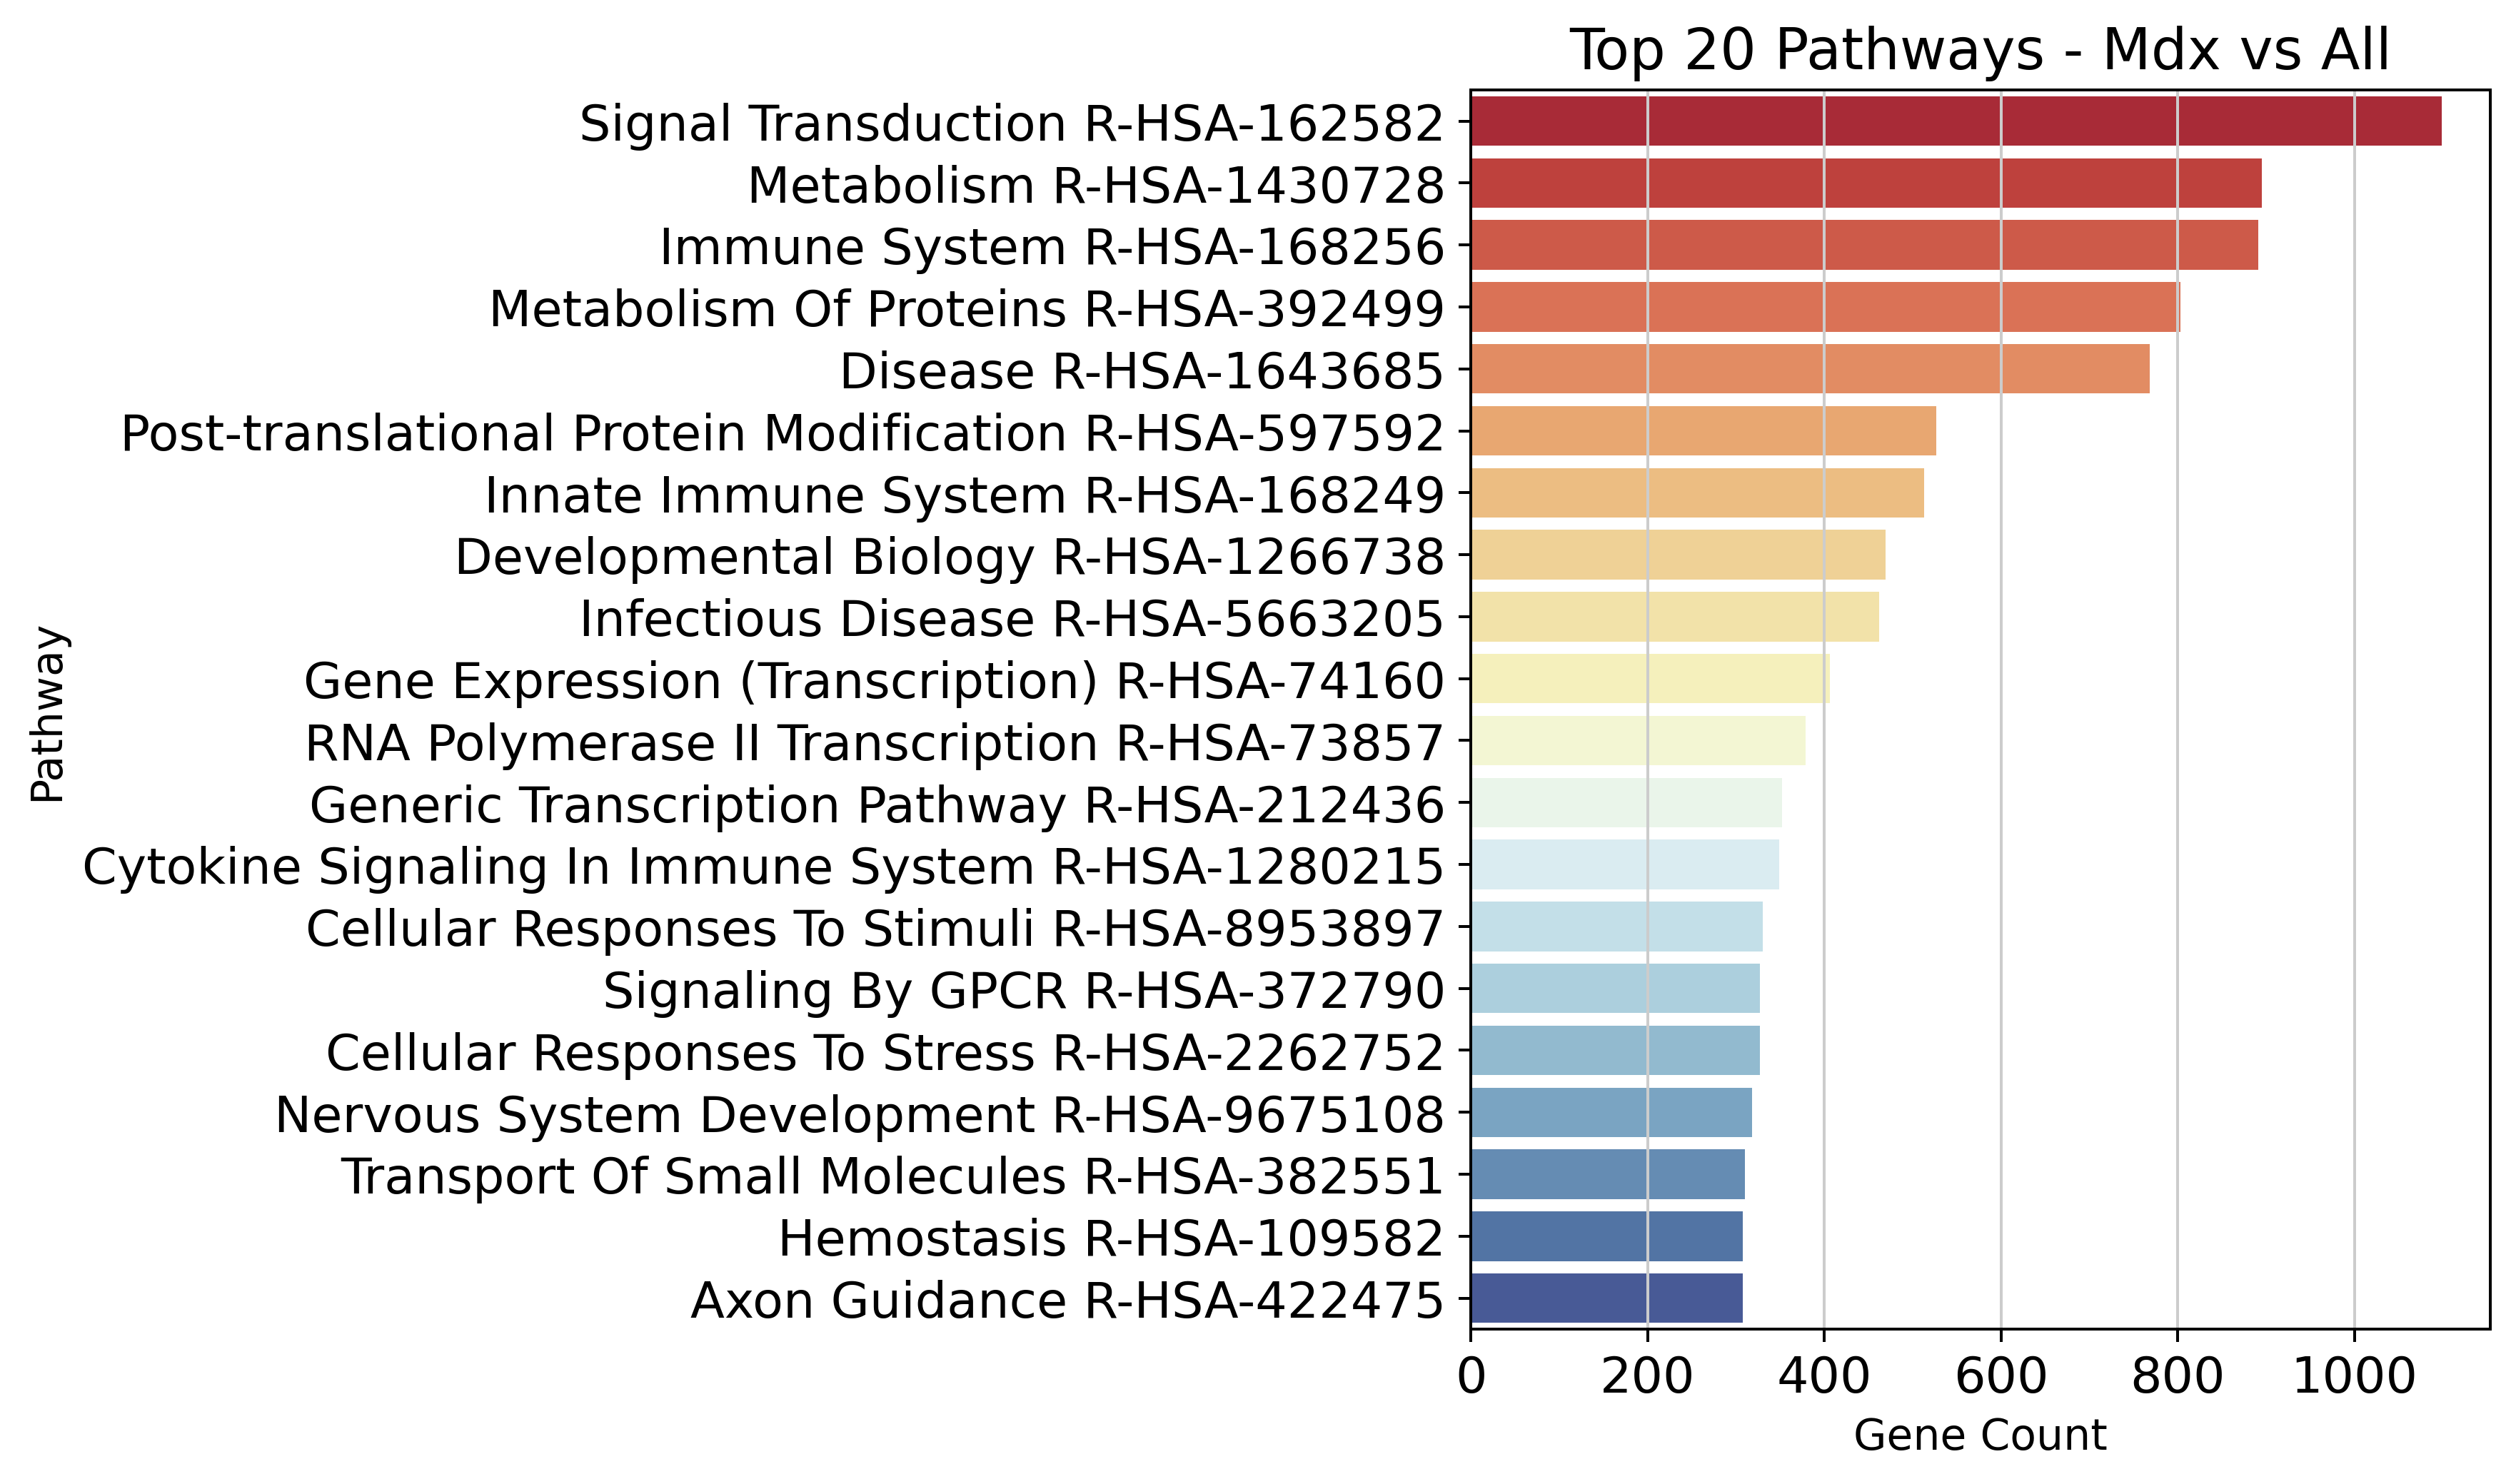

In [48]:
pathway_counts_sorted = pathway_counts_df.sort_values(by='Gene Count', ascending=False)

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Gene Count', y='Pathway', data=pathway_counts_sorted.head(top_n), palette='RdYlBu')
plt.title(f"Top {top_n} Pathways - Mdx vs All", fontsize=16)
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Pathway', fontsize=12)
plt.tight_layout()
plt.show()

## MdxSCID_vs_all

In [49]:
filtered = stat_res3.results_df[stat_res3.results_df['log2FoldChange'] > 0.5]
filtered

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gm1992     2.148276        1.191614  2.750653  0.433211  0.664861       NaN
Mrpl15   731.976396        1.292232  0.623675  2.071962  0.038269  0.462602
Alkal1     1.719591        1.317506  2.722061  0.484011  0.628378       NaN
Rrs1     166.913216        0.778182  0.603472  1.289508  0.197222  0.848515
Adhfe1   719.892480        0.638591  0.496389  1.286472  0.198278  0.849182
...             ...             ...       ...       ...       ...       ...
Gm28827    0.065341        1.082546  5.486113  0.197325  0.843573       NaN
Gm20837    0.065341        1.082546  5.486113  0.197325  0.843573       NaN
Gm21860    6.174756        3.100834  1.747571  1.774368  0.076002       NaN
Gm47283  804.296795        1.312454  0.574160  2.285867  0.022262  0.358917
Csprs     11.336849        0.501988  1.141500  0.439761  0.660110       NaN

[6812 rows x 6 columns]

In [50]:
filtered.index = filtered.index.str.upper()
filtered.index

Index(['GM1992', 'MRPL15', 'ALKAL1', 'RRS1', 'ADHFE1', 'VXN', 'SNHG6', 'TCF24',
       'PREX2', 'GM29283',
       ...
       'UBA1Y', 'GM21704', 'GM20838', 'GM28709', 'GM21317', 'GM28827',
       'GM20837', 'GM21860', 'GM47283', 'CSPRS'],
      dtype='object', length=6812)

In [51]:
genes = filtered.index.tolist()  
genes

['GM1992',
 'MRPL15',
 'ALKAL1',
 'RRS1',
 'ADHFE1',
 'VXN',
 'SNHG6',
 'TCF24',
 'PREX2',
 'GM29283',
 'PRDM14',
 'SBSPON',
 'RPL7',
 'GM7568',
 'ELOC',
 'TMEM70',
 'GM28376',
 'GM28153',
 'GM28756',
 'PAQR8',
 'EFHC1',
 'TMEM14A',
 'B3GAT2',
 'SDHAF4',
 'GM597',
 'PTP4A1-1',
 'GM28644',
 'LGSN',
 'KHDRBS2',
 'BAG2',
 'GM26788',
 'GM37958',
 'CCDC115',
 'PRSS40',
 'PLEKHB2',
 'GM37068',
 'GM37335',
 'FER1L5',
 'ANKRD23',
 'COX5B',
 'ACTR1B',
 'GM33533',
 'GM37020',
 'COA5',
 'UNC50',
 'MGAT4A',
 'LIPT1',
 'MRPL30',
 'GM15457',
 'TXNDC9',
 'EIF5B',
 'AFF3',
 'GM16151',
 'GM16152',
 'GM37707',
 'PDCL3',
 'NPAS2',
 'RPL31',
 'RFX8',
 'GM3646',
 'IL1R2',
 'SLC9A2',
 'GM37623',
 'GM37915',
 'GM28175',
 'PANTR1',
 'POU3F3',
 'MRPS9',
 'GM29040',
 'GM29155',
 'GM29157',
 'GM28826',
 'GM28319',
 'GM28320',
 'MYO1B',
 'GM28323',
 'GM31812',
 'GM29670',
 'HIBCH',
 'MSTN',
 'OSGEPL1',
 'ASNSD1',
 'CCDC150',
 'HSPD1',
 'HSPE1',
 'RFTN2',
 'HSFY2',
 'MAIP1',
 'GM17234',
 'KCTD18',
 'NDUFB3',
 'STR

In [52]:
batch_size = 500
gene_batches = [genes[i:i + batch_size] for i in range(0, len(genes), batch_size)]


background_type = "Reactome_2022"


pathway_results = {}

1. Provide all necessary url and 
2. Get the list of databases available to access

In [53]:
for i, gene_batch in enumerate(gene_batches):
    genes_str = '\n'.join(gene_batch)  
    payload = {'list': (None, genes_str), 'description': f'Pathway enrichment batch {i+1}'}


    for attempt in range(3):
        try:

            response = requests.post(enrichr_add_list_url, files=payload, timeout=10)
            if response.status_code == 200:
                user_list_id = response.json()['userListId']
                print(f"Batch {i+1} submitted successfully. User list ID: {user_list_id}")
                

                enrich_response = requests.get(f"{enrichr_enrich_url}?userListId={user_list_id}&backgroundType={background_type}", timeout=10)
                if enrich_response.status_code == 200:
                    enrichment_results = enrich_response.json()

                    if background_type in enrichment_results:
                        batch_df = pd.DataFrame(enrichment_results[background_type])

    
                        if len(batch_df) > 0:
                            if 'Term' in batch_df.columns:
                                pathway_column = 'Term'
                                genes_column = 'Genes'
                            elif 'Pathway' in batch_df.columns:
                                pathway_column = 'Pathway'
                                genes_column = 'Genes'
                            elif 1 in batch_df.columns and 5 in batch_df.columns:

                                pathway_column = 1
                                genes_column = 5
                            else:
                                print("Warning: Unknown pathway column structure in response.")
                                print("Unexpected batch structure:", batch_df.head())
                                continue


                            for _, row in batch_df.iterrows():
                                pathway = row[pathway_column]
                                genes_in_pathway = row[genes_column]

                                for gene in genes_in_pathway:
                                    if gene in pathway_results:
                                        pathway_results[gene].append(pathway)
                                    else:
                                        pathway_results[gene] = [pathway]
                break
            else:
                print(f"Error submitting batch {i+1} (Status code: {response.status_code})")
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for batch {i+1}: {e}")


Batch 1 submitted successfully. User list ID: 85701077
Batch 2 submitted successfully. User list ID: 85701078
Batch 3 submitted successfully. User list ID: 85701080
Batch 4 submitted successfully. User list ID: 85701081
Batch 5 submitted successfully. User list ID: 85701082
Batch 6 submitted successfully. User list ID: 85701083
Batch 7 submitted successfully. User list ID: 85701084
Batch 8 submitted successfully. User list ID: 85701085
Batch 9 submitted successfully. User list ID: 85701086
Batch 10 submitted successfully. User list ID: 85701087
Batch 11 submitted successfully. User list ID: 85701090
Batch 12 submitted successfully. User list ID: 85701092
Batch 13 submitted successfully. User list ID: 85701093
Batch 14 submitted successfully. User list ID: 85701094


In [54]:
pathway_results = {gene: ', '.join(pathways) for gene, pathways in pathway_results.items()}
pathways_df = pd.DataFrame.from_dict(pathway_results, orient='index', columns=['Pathways']).reset_index()
pathways_df.columns = ['Gene', 'Pathways']

filtered_with_pathways = filtered.merge(pathways_df, how='left', left_index=True, right_on='Gene')

filtered_with_pathways['Pathways'] = filtered_with_pathways['Pathways'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
print(filtered_with_pathways[['Gene', 'Pathways']])

         Gene                                           Pathways
NaN    GM1992                                                 []
5.0    MRPL15  [Mitochondrial Translation Elongation R-HSA-53...
NaN    ALKAL1                                                 []
NaN      RRS1                                                 []
15.0   ADHFE1  [Citric Acid (TCA) Cycle And Respiratory Elect...
...       ...                                                ...
NaN   GM28827                                                 []
NaN   GM20837                                                 []
NaN   GM21860                                                 []
NaN   GM47283                                                 []
NaN     CSPRS                                                 []

[6812 rows x 2 columns]


In [55]:
all_pathways = filtered_with_pathways['Pathways'].explode().dropna().unique().tolist()
all_pathways

['Mitochondrial Translation Elongation R-HSA-5389840',
 'Mitochondrial Translation Initiation R-HSA-5368286',
 'Mitochondrial Translation Termination R-HSA-5419276',
 'Mitochondrial Translation R-HSA-5368287',
 'Translation R-HSA-72766',
 'Metabolism Of Proteins R-HSA-392499',
 'Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517',
 'Pyruvate Metabolism And Citric Acid (TCA) Cycle R-HSA-71406',
 'Metabolism R-HSA-1430728',
 'RHOA GTPase Cycle R-HSA-8980692',
 'Regulation Of PTEN Stability And Activity R-HSA-8948751',
 'RAC1 GTPase Cycle R-HSA-9013149',
 'RHO GTPase Cycle R-HSA-9012999',
 'PIP3 Activates AKT Signaling R-HSA-1257604',
 'PTEN Regulation R-HSA-6807070',
 'CDC42 GTPase Cycle R-HSA-9013148',
 'Intracellular Signaling By Second Messengers R-HSA-9006925',
 'Signaling By Rho GTPases R-HSA-194315',
 'Signaling By Rho GTPases',
 'Miro GTPases And RHOBTB3 R-HSA-9716542',
 'Signal Transduction R-HSA-162582',
 'Transcriptional Regulation Of Pluripotent Stem Cell

Obtain the count of genes for each Pathway along with their Gene list

In [56]:
pathway_gene_counts = {}

for index, row in filtered_with_pathways.iterrows():
    gene_name = row['Gene']  
    pathways = row['Pathways']  
    

    for pathway in pathways:

        if pathway in pathway_gene_counts:
            pathway_gene_counts[pathway]['Gene Count'] += 1
            pathway_gene_counts[pathway]['Genes'].add(gene_name)  
        else:

            pathway_gene_counts[pathway] = {'Gene Count': 1, 'Genes': {gene_name}}


pathway_counts_df = pd.DataFrame([
    {'Pathway': pathway, 'Gene Count': data['Gene Count'], 'Genes': sorted(data['Genes'])}
    for pathway, data in pathway_gene_counts.items()
])


pathway_counts_df = pathway_counts_df.sort_values(by='Gene Count', ascending=False)
pathway_counts_df

Pathway  Gene Count  \
8                              Metabolism R-HSA-1430728         691   
5                   Metabolism Of Proteins R-HSA-392499         530   
20                     Signal Transduction R-HSA-162582         438   
30                                Disease R-HSA-1643685         386   
86                           Immune System R-HSA-168256         315   
...                                                 ...         ...   
1671                 Laminin Interactions R-HSA-3000157           1   
1672           MET Promotes Cell Motility R-HSA-8875878           1   
1674  TRIF-mediated Programmed Cell Death R-HSA-2562578           1   
1675  Caspase Activation Via Death Receptors In Pres...           1   
1676  FGFR3b Ligand Binding And Activation R-HSA-190371           1   

                                                  Genes  
8     [AANAT, AASDHPPT, ABCB4, ABCC2, ABCG2, ABO, AC...  
5     [AARS2, ACTR10, ADAMTS13, ADAMTS7, ADRA2A, ADR...  
20    [AAMP, ABCD3, ABCG5, ABHD17A, ACKR4, ACTC1, AD...  
30    [ABCB4, ABCC2, ABCG5, ACY1, ADA, ADAMTS13, ADA...  
86    [A1BG, AAMP, ACTR10, ACTR1B, AGPAT2, AKT1, ALA...  
...                                                 ...  
1671                                            [LAMA1]  
1672                                            [LAMA1]  
1674                                           [NDUFA2]  
1675                                           [NDUFA2]  
1676                                             [FGF1]  

[1696 rows x 3 columns]

In [57]:
apoptosis_related3 = pathway_counts_df[pathway_counts_df['Pathway'].str.contains("apoptosis", case=False)]

apoptosis_related3

Pathway  Gene Count  \
327                              Apoptosis R-HSA-109581          57   
510                Regulation Of Apoptosis R-HSA-169911          40   
596        Intrinsic Pathway For Apoptosis R-HSA-109606          11   
1056  Defective Intrinsic Pathway For Apoptosis R-HS...           5   
363   TP53 Regulates Transcription Of Additional Cel...           4   
1357             Suppression Of Apoptosis R-HSA-9635465           1   
1287   Apoptosis Induced DNA Fragmentation R-HSA-140342           1   

                                                  Genes  
327   [AKT1, APIP, BAK1, BAX, C1QBP, CASP6, CYCS, DI...  
510   [PSMA1, PSMA2, PSMA3, PSMA4, PSMA5, PSMA6, PSM...  
596   [AKT1, APIP, BAK1, BAX, C1QBP, CYCS, DIABLO, D...  
1056              [C1QBP, CAPNS1, CDC25C, PRDX1, PRDX2]  
363                         [BCL6, BIRC5, MPZ, RABGGTB]  
1357                                            [GSK3A]  
1287                                            [HMGB1]

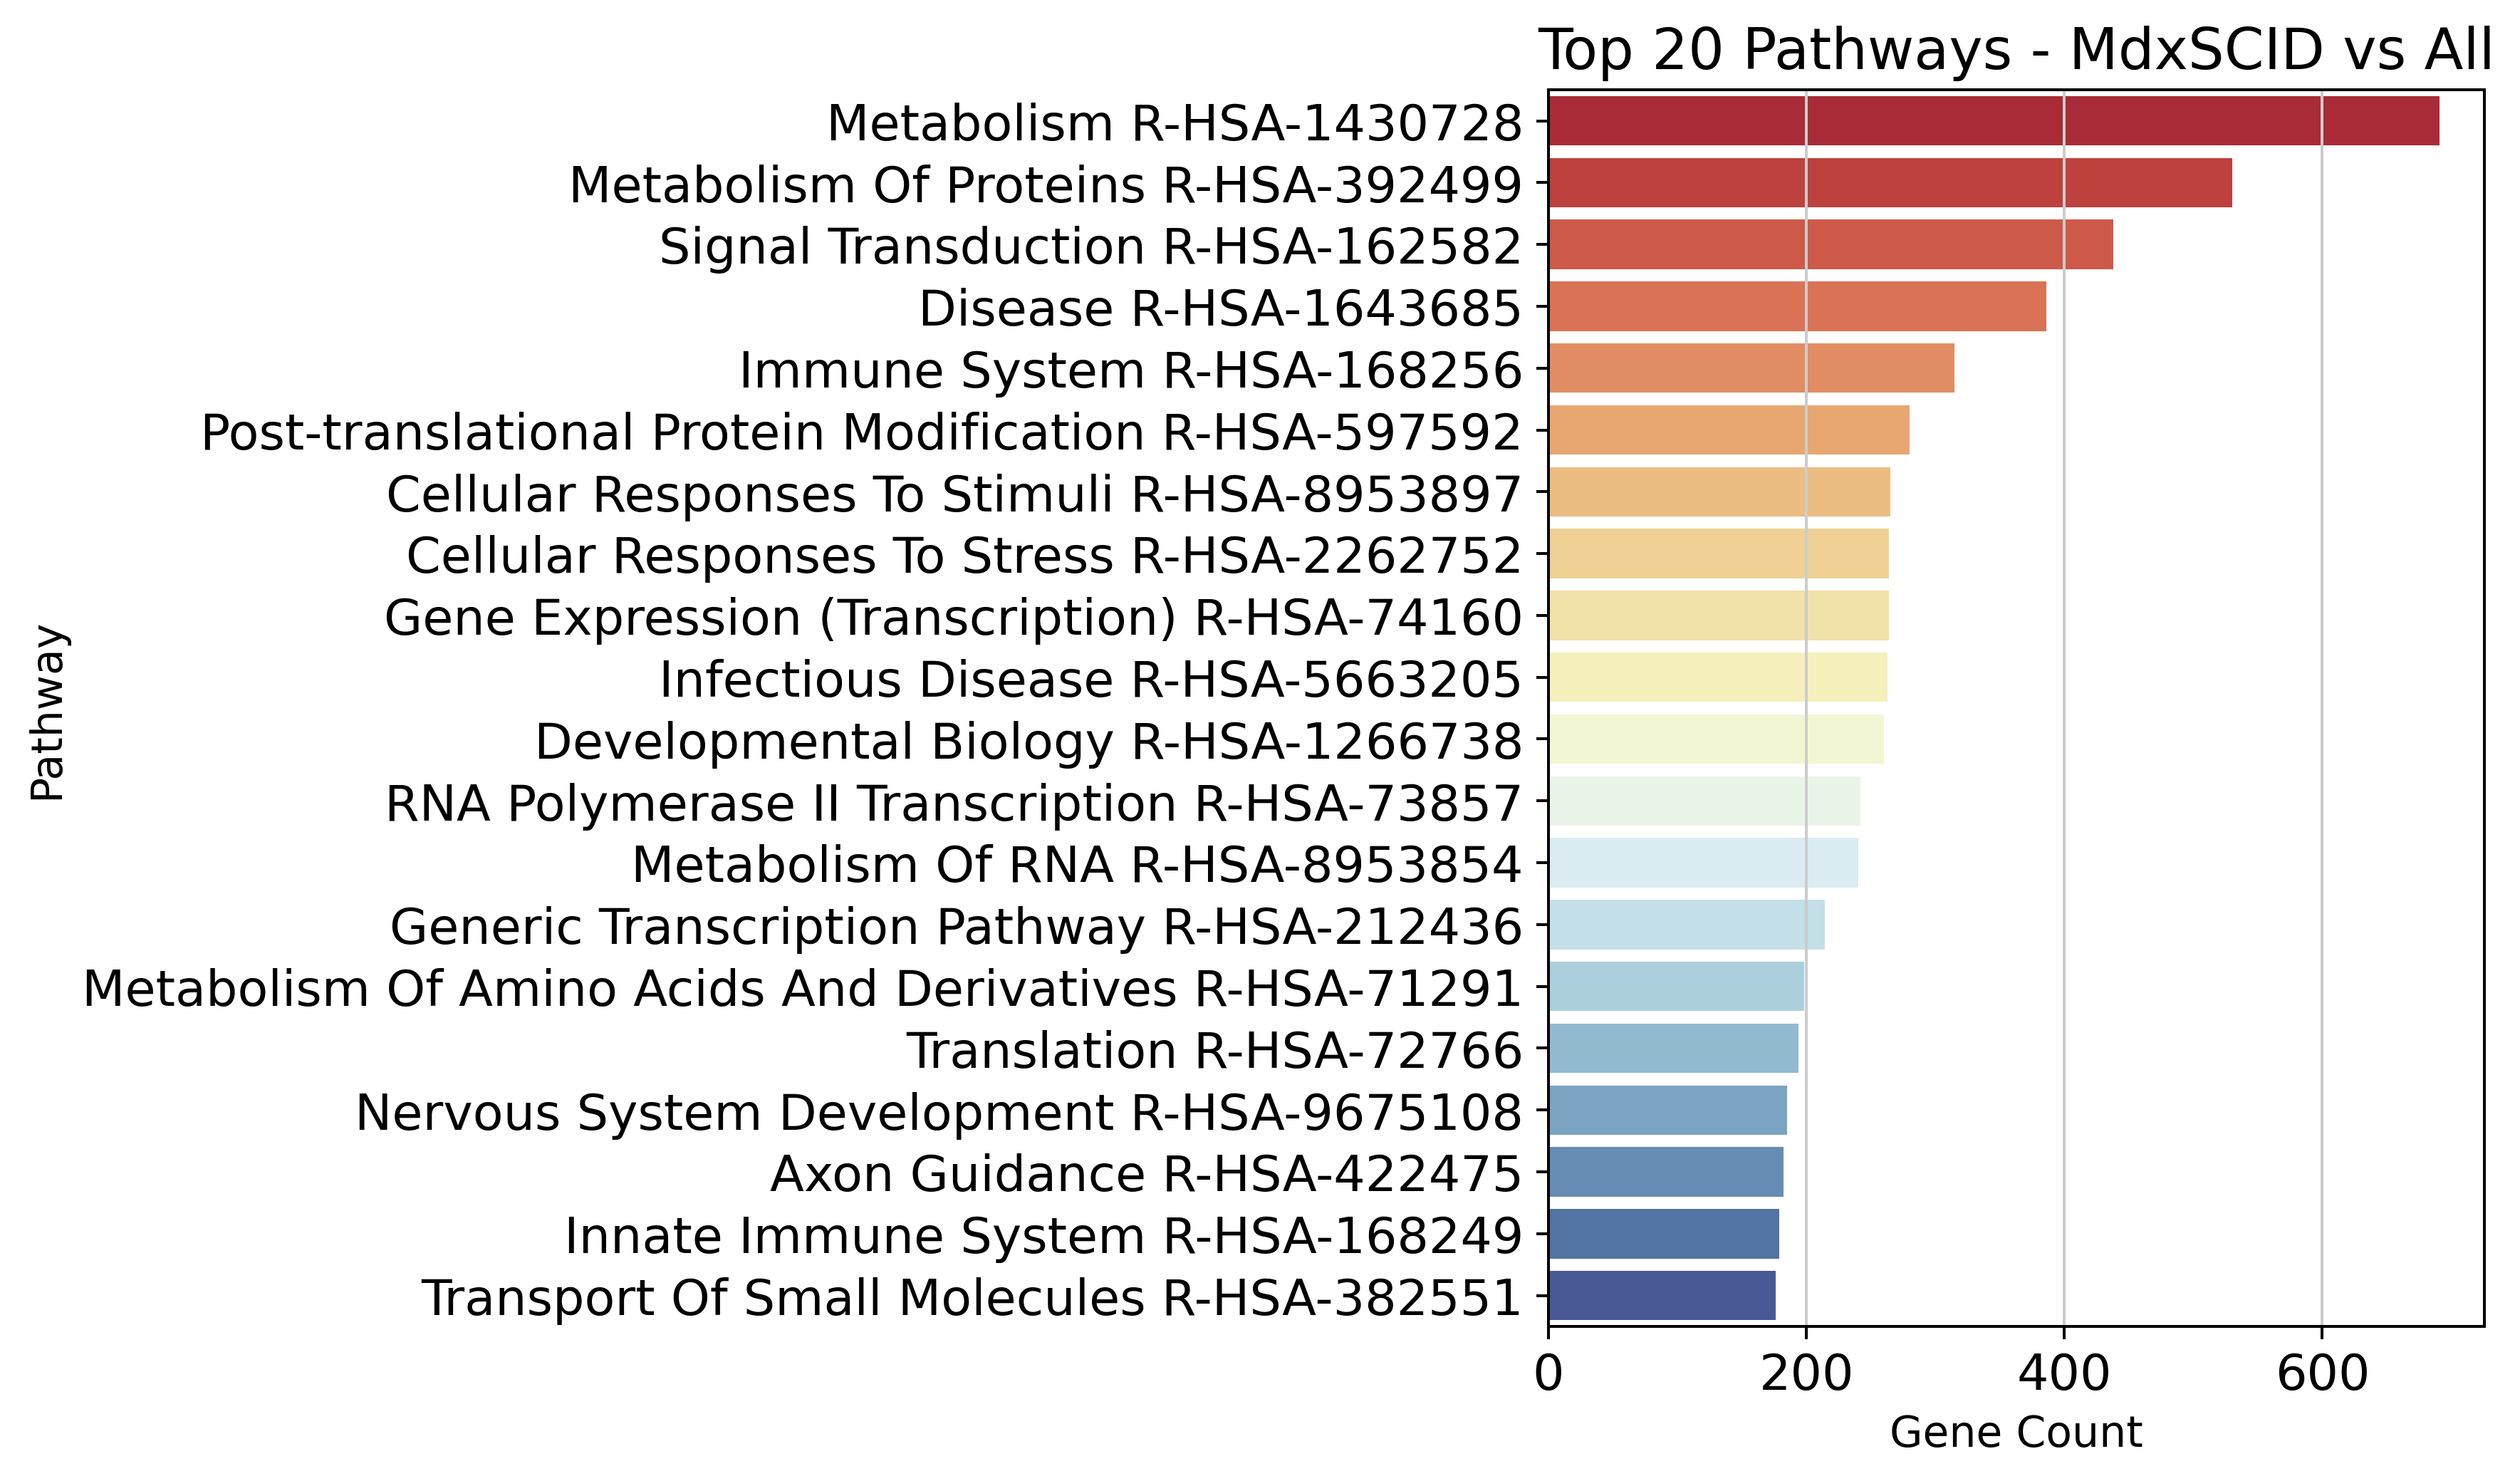

In [58]:
pathway_counts_sorted = pathway_counts_df.sort_values(by='Gene Count', ascending=False)

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Gene Count', y='Pathway', data=pathway_counts_sorted.head(top_n), palette='RdYlBu')
plt.title(f"Top {top_n} Pathways - MdxSCID vs All", fontsize=16)
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Pathway', fontsize=12)
plt.tight_layout()
plt.show()

## Plotting all apoptotic genes

In [59]:
apoptosis_genes1 = [gene for genes in apoptosis_related1['Genes'] for gene in genes]
apoptosis_genes2 = [gene for genes in apoptosis_related2['Genes'] for gene in genes]
apoptosis_genes3 = [gene for genes in apoptosis_related3['Genes'] for gene in genes]

In [60]:
X_is_raw(adata)

True

Filtered genes found in dataset: ['Trim27', 'Capns2', 'Capn2', 'Vim', 'Cdc25c', 'Psmb9', 'Psmb7', 'Dbnl', 'Casp3', 'Bid', 'Psma5', 'Fadd', 'Uaca', 'Unc5a', 'Apaf1', 'Cdc25b', 'Psmd4', 'Psmc1', 'Sem1', 'Bcl2l14', 'Bcl6', 'Psmb1', 'Cycs', 'Akt1', 'Maged1', 'Psmd8', 'Ywhae', 'Birc5', 'Capn1', 'Xiap', 'Ubc', 'Rabggtb', 'Gzmb', 'Rnf213', 'Bmx', 'Psmb10', 'Rabggta', 'Ndufa2', 'Proc', 'Psmc2', 'Tnfrsf10b', 'Ndrg1', 'Rexo2', 'Hmgb2', 'Psmb3', 'Mapk3', 'Gsk3a', 'Dsg3', 'Tradd', 'Lmna', 'Psmd12', 'Psmb11', 'Erc2', 'Hmgb1', 'Diablo', 'Ticam1', 'Psma3', 'Ubb', 'App', 'Psmd2', 'Psmb6', 'Psmb8', 'Dynll1', 'Psmb5', 'Bbc3', 'Dapk3', 'Bmf', 'Casp6', 'Cdkn2a', 'Bad', 'Stk26', 'Ywhah', 'Psmd7', 'Sptan1', 'Psmc4', 'Psma8', 'Ctsg', 'Casp8', 'Psmc3', 'Jun', 'Ocln', 'Capns1', 'Ywhab', 'Cdc25a', 'E2f1', 'Gsdme', 'Unc5b', 'Bak1', 'Dynll2', 'Psma6', 'Psmd13', 'Psme2', 'Psmc6', 'Prdx1', 'Dcc', 'Kpnb1', 'Rps27a', 'Uba52', 'Fasn', 'Ripk1', 'Bcap31', 'Pkp1', 'Gsdmd', 'Psmd3', 'Psme1', 'Psma2', 'Dapk1', 'Foxo3', 'Pm

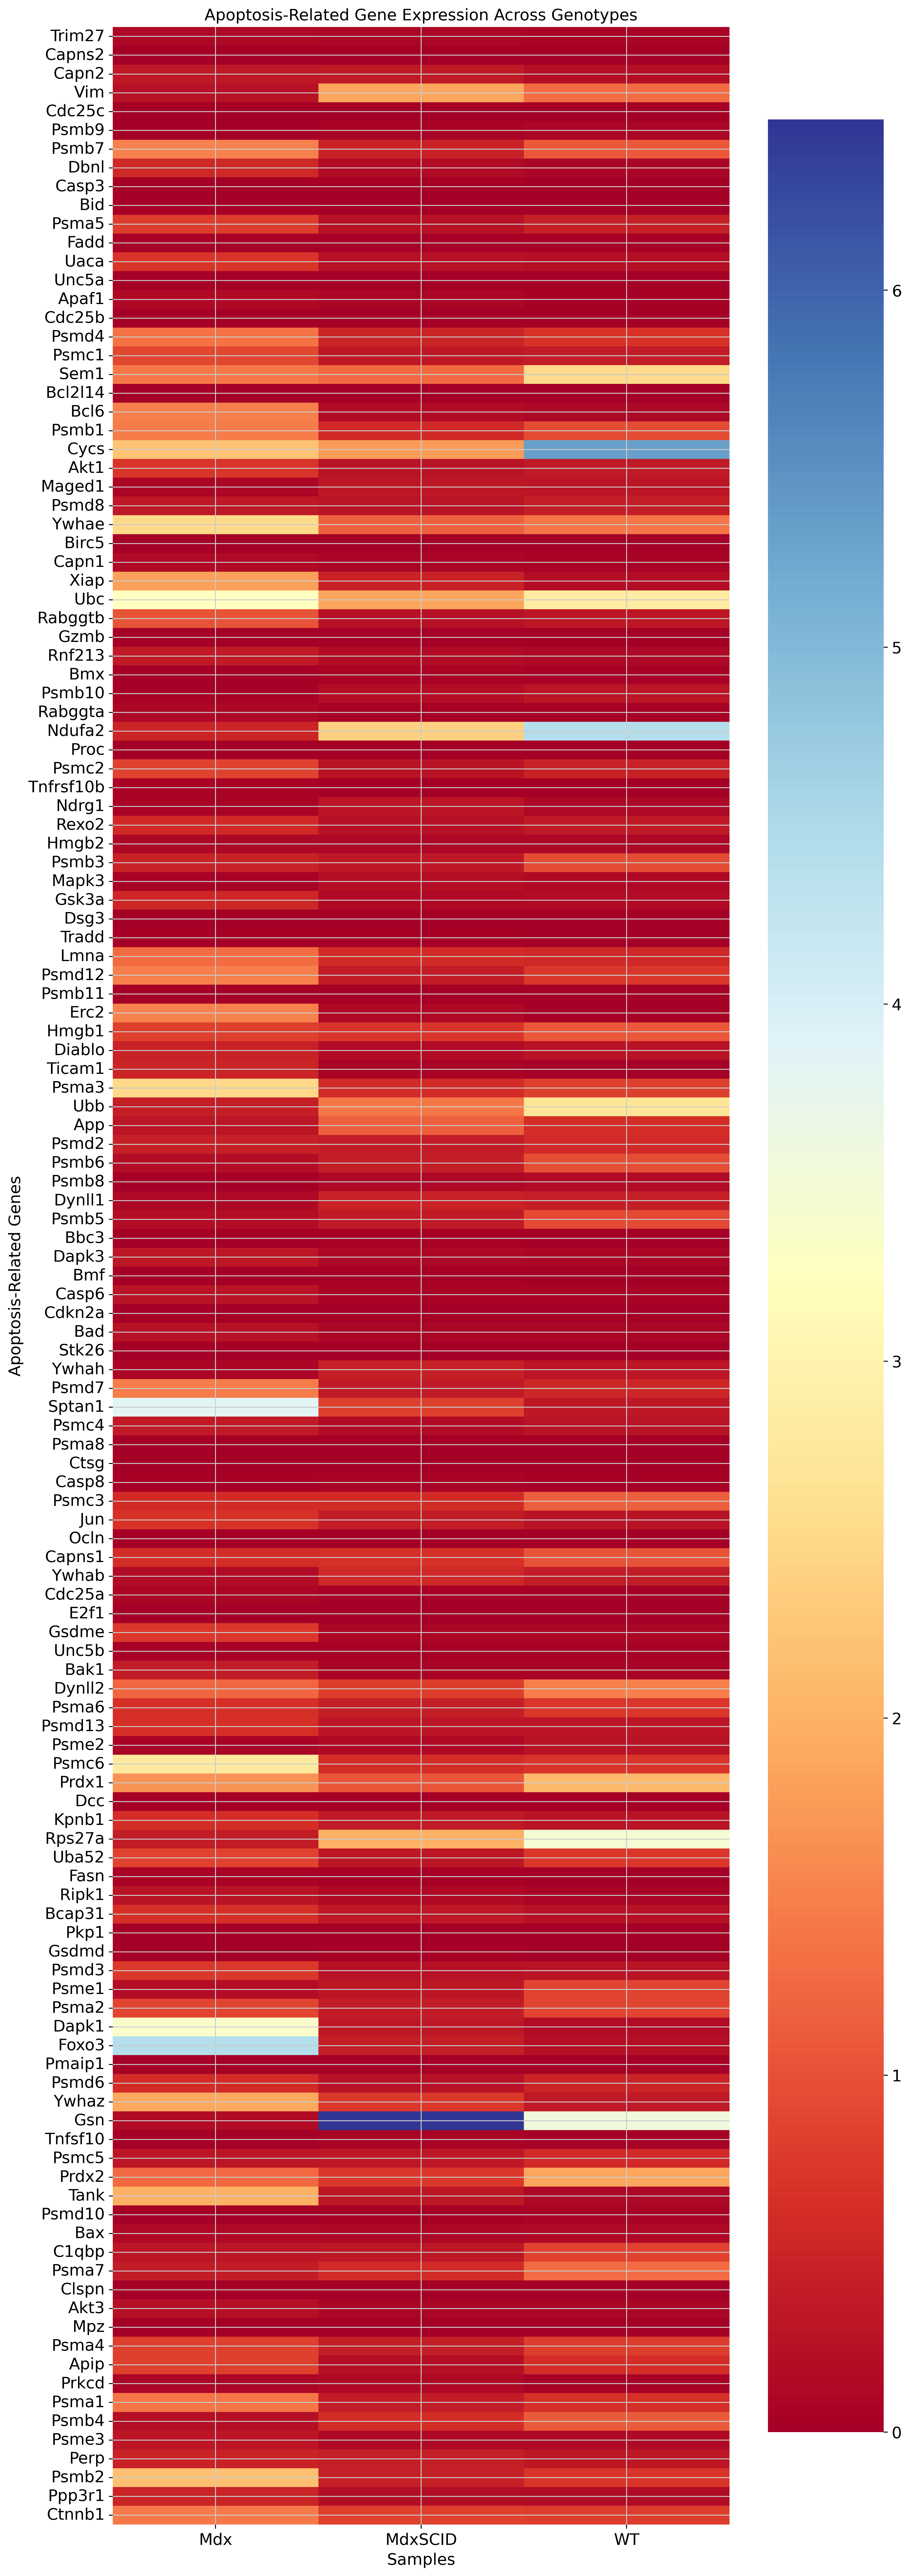

In [61]:
all_apoptosis_genes = list(set([gene.capitalize() for genes in [apoptosis_genes1, apoptosis_genes2, apoptosis_genes3] for gene in genes]))
filtered_genes = [gene for gene in all_apoptosis_genes if gene in adata.var_names]

if not filtered_genes:
    raise ValueError("None of the apoptosis-related genes are found in the dataset.")
else:
    print(f"Filtered genes found in dataset: {filtered_genes}")

gene_indices = [adata.var_names.get_loc(gene) for gene in filtered_genes]

sc.pp.normalize_total(adata, target_sum= 1e6)
sc.pp.log1p(adata)

expression_data = adata.X

if issparse(expression_data):
    expression_data = expression_data.toarray()

apoptosis_expr = expression_data[:, gene_indices]

apoptosis_expr_df = pd.DataFrame(apoptosis_expr, columns=filtered_genes, index=adata.obs_names)
apoptosis_expr_df['genotype'] = adata.obs['genotype'].values  
apoptosis_expr_by_sample = apoptosis_expr_df.groupby('genotype').mean()

if apoptosis_expr_by_sample.isnull().all().all():
    raise ValueError("The aggregated DataFrame still contains all NaN values. Check sample and gene indexing.")
else:
    print("Aggregated apoptosis gene expression by sample:", apoptosis_expr_by_sample)


plt.figure(figsize=(12, len(filtered_genes) * 0.3))
sns.heatmap(apoptosis_expr_by_sample.T, cmap='RdYlBu', annot=False, cbar=True)
plt.title("Apoptosis-Related Gene Expression Across Genotypes")
plt.xlabel("Samples")
plt.ylabel("Apoptosis-Related Genes")
plt.savefig(f'../differential_gene_expression/figures/plots/apoptotic_de_genes.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
pathway_1_genes = apoptosis_related1['Genes'].explode().str.capitalize().tolist()  # Convert gene names to capitalized
pathway_2_genes = apoptosis_related2['Genes'].explode().str.capitalize().tolist()  # Convert gene names to capitalized
pathway_3_genes = apoptosis_related3['Genes'].explode().str.capitalize().tolist()  # Convert gene names to capitalized

In [79]:
apoptosis_related1

Pathway  Gene Count  \
607                              Apoptosis R-HSA-109581          21   
783        Intrinsic Pathway For Apoptosis R-HSA-109606           9   
849   Defective Intrinsic Pathway For Apoptosis R-HS...           5   
1351  TP53 Regulates Transcription Of Additional Cel...           2   
1439   Apoptosis Induced DNA Fragmentation R-HSA-140342           1   
1404             Suppression Of Apoptosis R-HSA-9635465           1   

                                                  Genes  
607   [APAF1, BMF, CASP3, CLSPN, DAPK1, DBNL, E2F1, ...  
783   [APAF1, BMF, CASP3, E2F1, GZMB, MAPK3, PMAIP1,...  
849                  [APP, CAPNS2, CDC25B, ERC2, FOXO3]  
1351                                   [BCL2L14, NDRG1]  
1439                                            [CASP3]  
1404                                            [MAPK3]

In [84]:
pathway_1_results = stat_res1.results_df[stat_res1.results_df.index.isin(pathway_1_genes)]
pathway_2_results = stat_res2.results_df[stat_res2.results_df.index.isin(pathway_2_genes)]
pathway_3_results = stat_res3.results_df[stat_res3.results_df.index.isin(pathway_3_genes)]

# Extract log fold changes and p-values for each pathway
logfc_pvalues_pathway_1 = pathway_1_results[['log2FoldChange', 'pvalue']]
logfc_pvalues_pathway_2 = pathway_2_results[['log2FoldChange', 'pvalue']]
logfc_pvalues_pathway_3 = pathway_3_results[['log2FoldChange', 'pvalue']]

# Combine the results into a single DataFrame for all pathways
combined_results = pd.concat([
    logfc_pvalues_pathway_1.assign(comparision='Wt vs all'),
    logfc_pvalues_pathway_2.assign(comparision="Mdx vs all"),
    logfc_pvalues_pathway_3.assign(comparision="MdxSCID vs all")
])
combined_results

log2FoldChange    pvalue     comparision
Sptan1        0.645704  0.174415       Wt vs all
Gsn           1.166257  0.085320       Wt vs all
Tank          0.751589  0.118422       Wt vs all
Bmf           0.559810  0.519712       Wt vs all
Cdc25b        0.908989  0.391692       Wt vs all
...                ...       ...             ...
Psmb8         0.743758  0.296136  MdxSCID vs all
Dsg3          1.141554  0.579339  MdxSCID vs all
Cdc25c        1.676163  0.666136  MdxSCID vs all
Ndufa2        1.541375  0.021114  MdxSCID vs all
Psmd10        1.191875  0.154712  MdxSCID vs all

[199 rows x 3 columns]

In [88]:
combined_results.to_csv(f'../differential_gene_expression/DE_results/apoptosis_genes_logfc_pvalues_combined_{timestamp}.csv')